# Classification 2: Discriminative methods

## StatML: Lecture 7

## Prof. James Sharpnack

- Some content and images are from "The Elements of Statistical Learning" by Hastie, Tibshirani, Friedman
- Reading ESL Chapter 4

### Binary Classification

Given $x \in \mathbb R^p$, predict $y \in \{-1,1\}$.
For notational convenience, we will re-encode $\{0,1\}$ as $\{-1,1\}$.

Could simply train a regression $\hat f$ which predicts $y$ as if it was continuous, $\hat f(x) \in \mathbb R$, then use 
$$ \hat y = \text{sign}(\hat f(x)). $$

### Exercise 7.1
Why might it not be a good idea to simply threshold a regression for binary classification?

### Linear discriminative classifiers

Output is a linear function of $x$ (with intercept):
$$\hat f(x) = \hat \beta_0 + \hat \beta^\top x$$

Predicts:
$$\hat y(x) = \textrm{sign} (\hat f(x)) = \left\{ \begin{array}{ll}  1, &\hat f(x) \ge 0\\ -1, &\textrm{otherwise} \end{array}\right.$$

- at $0$ you may flip a coin as a tie breaker, this happens with KNN with even K
- fit method will fit $\hat \beta, \hat \beta_0$
- typically, I will let $x_0 = 1$ and $\hat \beta \in \mathbb R^{p+1}$

### Loss function measures the success of predict

Recall, loss function determines how we evaluate
$$
\ell_{0/1} (\hat y_{i}, y_i) = \left\{ \begin{array}{ll}
1,& \textrm{ if } \hat y_i \ne y_i\\
0,& \textrm{ if } \hat y_i = y_i
\end{array} \right.
$$

- Correct or not
- Test error is then misclassification rate

### What we want to do

Suppose that we wanted to minimize training error with a 0-1 training loss.  Then this could be written as the optimization program,
$$
\min_{\beta \in \mathbb R^{p+1}}.\frac{1}{n_0} \sum_{i=1}^{n_0} 1 \{ \textrm{sign}(\beta^\top x_i) \ne y_i \}.
\tag{0-1 min}
$$
- discontinuous because it is the sum of discontinuous functions
- hard to optimize in most situations, often NP-hard

In [28]:
def lm_sim(N = 100):
    """simulate a binary response and two predictors"""
    X1 = (np.random.randn(N*2)).reshape((N,2)) + np.array([2,3])
    X0 = (np.random.randn(N*2)).reshape((N,2)) + np.array([.5,1.5])
    y = - np.ones(N*2)
    y[:N]=1
    X = np.vstack((X1,X0))
    return X, y, X0, X1

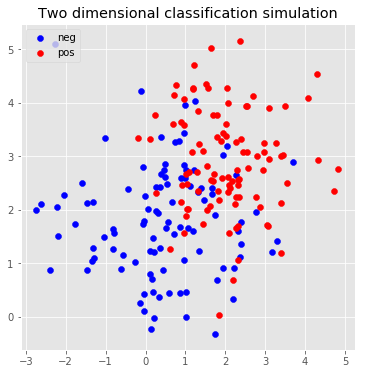

In [30]:
X_sim,y_sim,X0,X1 = lm_sim()
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.title("Two dimensional classification simulation")
_ = plt.legend(loc=2)

In [46]:
lr_sim = linear_model.LogisticRegression()
lr_sim.fit(X_sim,y_sim)

beta1 = lr_sim.coef_[0,0]
beta2 = lr_sim.coef_[0,1]
beta0 = lr_sim.intercept_

mults=0.8
T = np.linspace(-1,4,100)
x2hat = -(beta0 + beta1*T) / beta2
line1 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line2 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line3 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)

In [47]:
def plt_tmp():
    plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
    plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
    plt.plot(T,line3,c='k')
    plt.plot(T,line1,c='k')
    plt.plot(T,line2,c='k')
    plt.ylim([-1,7])
    plt.title("Three possible separator lines")
    _ = plt.legend(loc=2)

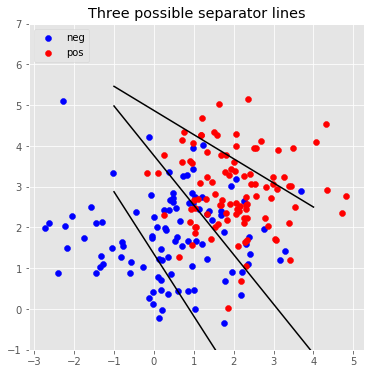

In [48]:
plt_tmp()

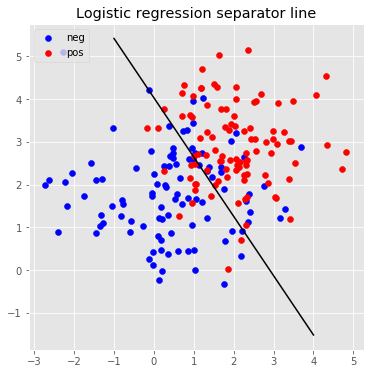

In [49]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.title("Logistic regression separator line")
_ = plt.legend(loc=2)

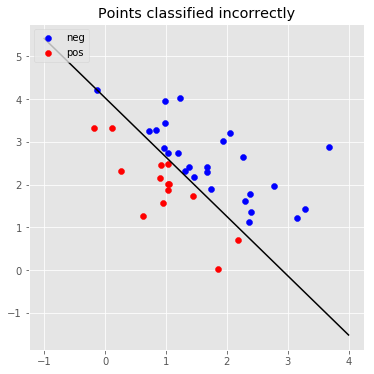

In [50]:
N = 100
y_hat = lr_sim.predict(X_sim)
plt.scatter(X0[y_hat[N:] == 1,0],X0[y_hat[N:] == 1,1],c='b',label='neg')
plt.scatter(X1[y_hat[:N] == -1,0],X1[y_hat[:N] == -1,1],c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.title("Points classified incorrectly")
_ = plt.legend(loc=2)

### Exercise 7.2

Show that a classifier $\hat y_i = \text{sign}(\beta^\top x_i)$ is defined by a separating hyperplane.  Assume that $\beta \in \mathbb R^{p+1}$ and $x_{i0} = 1$.  Specifically, convince yourself that there is a hyperplane such that $\hat y_i = 1$ is on one side of the hyperplane and $\hat y_i = -1$ is on the other side.  What is a normal vector to this hyperplane?

### Answer to Exercise 7.2 

A hyperplane is an equation of the form, 
$$ b^\top x = a $$
and denoting $x',\beta'$ to be the coordinates $1,\ldots,p$ of the vectors,
$$ \beta^\top x_i = \beta_0 + \beta'^\top x'_i.$$
So the equation $\beta^\top x_i = 0$ is equivalent to
$$-\beta_0 = \beta'^\top x'_i $$
And to be on one side of the hyperplane means that 
$$-\beta_0 < \beta'^\top x'_i$$
and $>$ for the other side.

Also, $\beta'$ is the normal vector.

### Surrogate losses

$$
\min_{\beta \in \mathbb R^{p+1}}.\frac{1}{n_0} \sum_{i=1}^{n_0} 1 \{ \textrm{sign}(\beta^\top x_i) \ne y_i \}.
\tag{0-1 min}
$$

Rewrite the 0-1 loss for a linear classifier,
$$
\ell_{0/1}(\beta,x_i,y_i) = 1 \{ y_i \beta^\top x_i < 0 \}.
$$

The logistic loss and the hinge loss are also functions of $y_i \beta^\top x_i$,
$$
\ell_{L} (\beta, x_i, y_i) = \log(1 + \exp(-y_i \beta^\top x_i))
\tag{logistic}
$$
$$
\ell_{H} (\beta, x_i, y_i) = (1 - y_i \beta^\top x_i))_+
\tag{hinge}
$$
where $a_+ = a 1\{ a > 0\}$ is the positive part of the real number $a$.

In [57]:
def plt_tmp():
    z_range = np.linspace(-5,5,200)
    zoloss = z_range < 0
    hingeloss = (1 - z_range) * (z_range < 1)
    logisticloss = np.log(1 + np.exp(-z_range))
    plt.plot(z_range, logisticloss + 1 - np.log(2.),label='logistic')
    plt.plot(z_range, zoloss,label='0-1')
    plt.plot(z_range, hingeloss,label='hinge')
    plt.ylim([-.2,5])
    plt.xlabel(r'$y_i \beta^\top x_i$')
    plt.ylabel('loss')
    plt.title('A comparison of classification loss functions')
    _ = plt.legend()

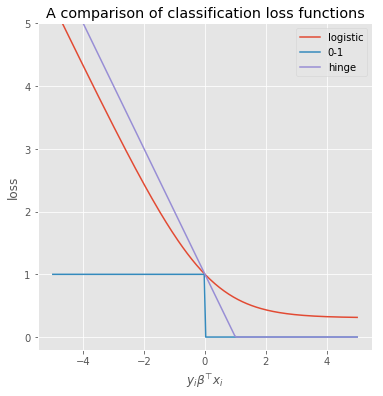

In [58]:
plt_tmp()

In [67]:
z_log = y_sim*lr_sim.decision_function(X_sim)
def plt_tmp():
    logisticloss = np.log(1 + np.exp(-z_log))
    plt.scatter(X0[:,0],X0[:,1],s=logisticloss[N:]*30.,c='b',label='neg')
    plt.scatter(X1[:,0],X1[:,1],s=logisticloss[:N]*30.,c='r',label='pos')
    plt.plot(T,x2hat,c='k')
    plt.xlim([-1,3])
    plt.ylim([0,4])
    plt.title("Points weighted by logistic loss")
    _ = plt.legend(loc=2)

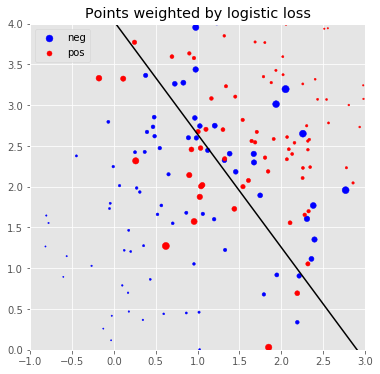

In [68]:
plt_tmp()

In [69]:
def plt_tmp():
    hingeloss = (1-z_log)*(z_log < 1)
    plt.scatter(X0[:,0],X0[:,1],s=hingeloss[N:]*30.,c='b',label='neg')
    plt.scatter(X1[:,0],X1[:,1],s=hingeloss[:N]*30.,c='r',label='pos')
    plt.plot(T,x2hat,c='k')
    plt.xlim([-1,3])
    plt.ylim([0,4])
    plt.title("Points weighted by hinge loss")
    _ = plt.legend(loc=2)

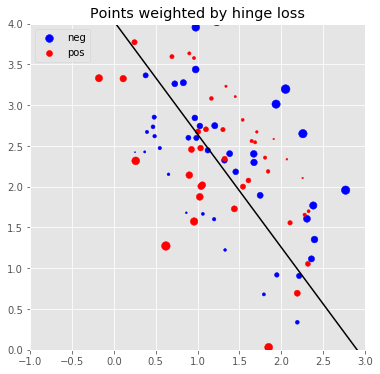

In [70]:
plt_tmp()

In [71]:
def plt_tmp():
    l2loss = (1-z_log)**2.
    plt.scatter(X0[:,0],X0[:,1],s=l2loss[N:]*10.,c='b',label='neg')
    plt.scatter(X1[:,0],X1[:,1],s=l2loss[:N]*10.,c='r',label='pos')
    plt.plot(T,x2hat,c='k')
    plt.xlim([-1,3])
    plt.ylim([0,4])
    plt.title("Points weighted by sqr. loss")
    _ = plt.legend(loc=2)

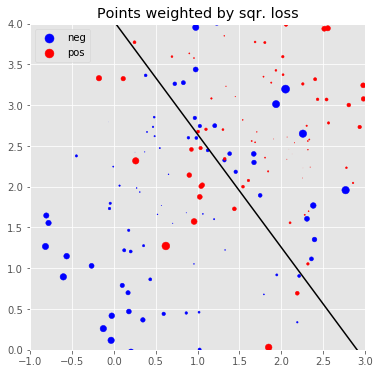

In [72]:
plt_tmp()

### Square error loss?

If we are free to select training loss functions, then why not square error loss?
$$
\ell_{S} (\beta, x_i, y_i) = (y_i - \beta^\top x_i)^2 = (1 - y_i \beta^\top x_i)^2.
\tag{square error}
$$

In [60]:
def plt_tmp():
    z_range = np.linspace(-5,5,200)
    zoloss = z_range < 0
    l2loss = (1-z_range)**2.
    hingeloss = (1 - z_range) * (z_range < 1)
    logisticloss = np.log(1 + np.exp(-z_range))
    plt.plot(z_range, logisticloss + 1 - np.log(2.),label='logistic')
    plt.plot(z_range, zoloss,label='0-1')
    plt.plot(z_range, hingeloss,label='hinge')
    plt.plot(z_range, l2loss,label='sq error')
    plt.ylim([-.2,5])
    plt.xlabel(r'$y_i \beta^\top x_i$')
    plt.ylabel('loss')
    plt.title('A comparison of classification loss functions')
    _ = plt.legend()

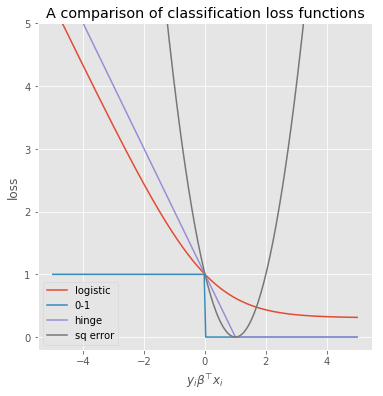

In [61]:
plt_tmp()

### Ridge terms

Ridge regularization can be added to these programs,
$$
\min_{\beta \in \mathbb R^{p+1}}. \frac 1n \sum_{i=1}^n \ell(\beta,x_i,y_i) + \lambda \sum_{j=1}^p \beta_j^2.
$$

- SVMs have non-unique solutions without the ridge terms, it always appears
- Logistic regression often runs without ridge penalty

In [73]:
lamb = 1.
lr = linear_model.LogisticRegression(penalty='l2', C = 1/lamb)
lr.fit(X_tr,y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [74]:
yhat = lr.predict(X_te)
(yhat != y_te).mean()

0.10187667560321716

In [75]:
score_lr = X_te @ lr.coef_[0,:]
fpr_lr, tpr_lr, threshs = metrics.roc_curve(y_te,score_lr)
prec_lr, rec_lr, threshs = metrics.precision_recall_curve(y_te,score_lr)

In [76]:
lamb = 1.
svc = svm.SVC(C = 1/lamb,kernel='linear')
svc.fit(X_tr,y_tr)
yhat = svc.predict(X_te)
score_svc = X_te @ svc.coef_[0,:]
fpr_svc, tpr_svc, threshs = metrics.roc_curve(y_te,score_svc)
prec_svc, rec_svc, threshs = metrics.precision_recall_curve(y_te,score_svc)
(yhat != y_te).mean()

0.10656836461126006

Text(0.5, 1.0, 'ROC curve comparison')

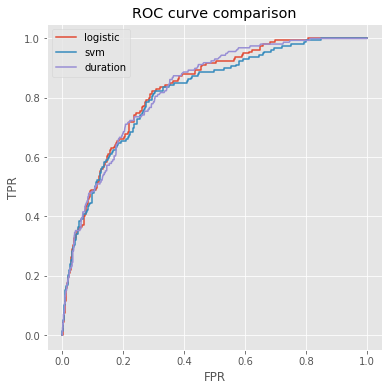

In [80]:
plt.figure(figsize=(6,6))
plt.plot(fpr_lr,tpr_lr,label='logistic')
plt.plot(fpr_svc,tpr_svc,label='svm')
plt.plot(fpr_dur,tpr_dur,label='duration')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title("ROC curve comparison")

Text(0.5, 1.0, 'PR curve comparison')

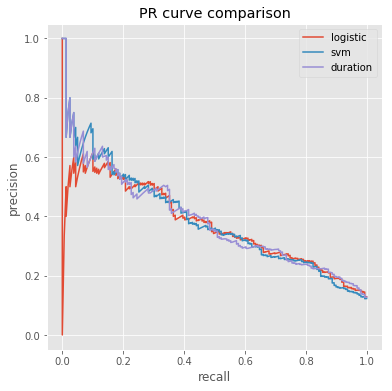

In [79]:
plt.figure(figsize=(6,6))
plt.plot(rec_lr,prec_lr,label='logistic')
plt.plot(rec_svc,prec_svc,label='svm')
plt.plot(rec_dur,prec_dur,label='duration')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.title("PR curve comparison")

### Other narratives: Logistic model

Logistic loss is -log-likelihood for logistic model
$$
\log \frac{\mathbb P\{Y = 1 | X = x \}}{\mathbb P\{ Y = -1 | X = x \}} = x^\top \beta
$$
for some $\beta \in \mathbb R^{p+1}$.

$$
-\log \mathbb P\{ Y = y | X = x \} = \ell_{L} (\beta, x, y) = \log(1 + \exp(-y \beta^\top x))
$$

To verify,
$$
\log \frac{\exp (- \ell_{L} (\beta, x, 1))}{\exp(- \ell_{L} (\beta, x, -1))} = -\log(1 + \exp(-\beta^\top x)) + \log(1 + \exp(\beta^\top x))
$$
$$
= \log\left( \frac{1 + \exp(\beta^\top x)}{1 + \exp(-\beta^\top x)}\right) = \log \exp (x^\top \beta) = x^\top \beta
$$

### Other narratives: Support vector machines

Suppose that our data was linearly separable:

In [101]:
def lm_sim(N = 100,sig=.25):
    """simulate a binary response and two predictors"""
    X1 = 2*sig*(np.random.randn(N*2)).reshape((N,2)) + np.array([2,3])
    X0 = sig*(np.random.randn(N*2)).reshape((N,2)) + np.array([.5,1.5])
    y = - np.ones(N*2)
    y[:N]=1
    X = np.vstack((X1,X0))
    return X, y, X0, X1

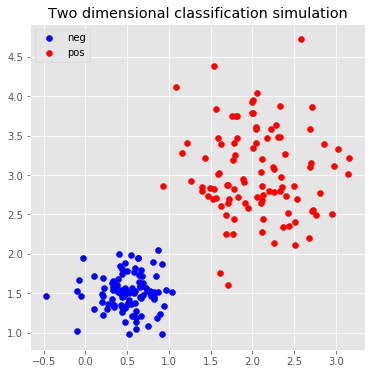

In [107]:
X_sim,y_sim,X0,X1 = lm_sim()
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.title("Two dimensional classification simulation")
_ = plt.legend(loc=2)

In [108]:
lr_sim = linear_model.LogisticRegression()
lr_sim.fit(X_sim,y_sim)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
beta1 = lr_sim.coef_[0,0]
beta2 = lr_sim.coef_[0,1]
beta0 = lr_sim.intercept_
x2hat = -(beta0 + beta1*T) / beta2
T = np.linspace(-.2,3,100)

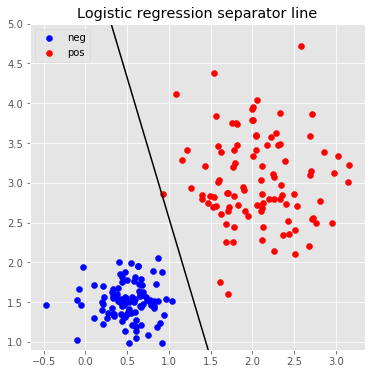

In [111]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.ylim([.9,5])
plt.title("Logistic regression separator line")
_ = plt.legend(loc=2)

### How to choose the separator line?

The *margin* is a pair of lines,
$$
x^\top \beta = \pm 1
$$
for a linearly separable dataset there is a margin such that
$$
y = +1 \Rightarrow x^\top \beta \ge 1
$$
$$
y = -1 \Rightarrow x^\top \beta \le -1
$$
Can write separation of data as 
$$
y_i x_i^\top \beta \ge 1
$$

In [121]:
svm_sim = svm.SVC(kernel="linear")
svm_sim.fit(X_sim,y_sim)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [154]:
T = np.linspace(-.2,3,100)
beta1 = svm_sim.coef_[0,0]
beta2 = svm_sim.coef_[0,1]
beta0 = np.array([-3.975, -4.425, -4.875])
x2hat = np.zeros((100,3))
for j, b0 in enumerate(beta0):
    x2hat[:,j] = -(b0 + beta1*T) / beta2

In [157]:
def plt_tmp():
    plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
    plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
    plt.plot(T,x2hat[:,2],'k:')
    plt.plot(T,x2hat[:,1],'k')
    plt.plot(T,x2hat[:,0],'k:')
    plt.ylim([.9,5])
    plt.title("Logistic regression separator line")
    _ = plt.legend(loc=2)

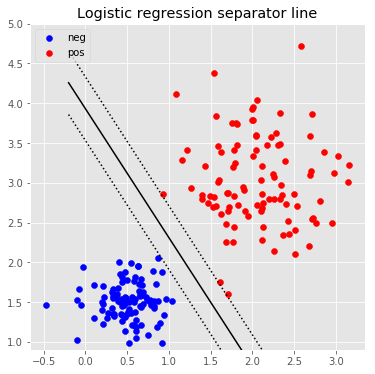

In [158]:
plt_tmp()

### Large-margin classifier

The margin width is smallest distance between these points, 
$$
x_\alpha = \alpha \frac{\beta}{\| \beta\|},
$$
then on one side of margin
$$
x_\alpha^\top \beta = \alpha \| \beta \| = 1
$$
and on other side 
$$
x_\alpha^\top \beta = \alpha \| \beta \| = -1.
$$
So $\alpha = \pm 1/ \| \beta \|$, and margin width is $2 / \| \beta \|$.

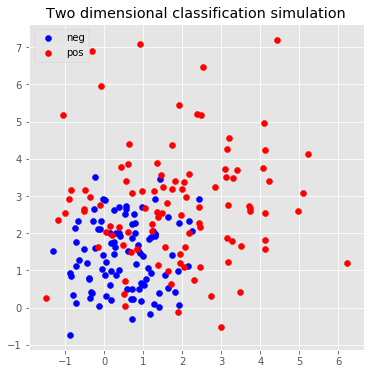

In [165]:
X_sim,y_sim,X0,X1 = lm_sim(sig=.8)
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.title("Two dimensional classification simulation")
_ = plt.legend(loc=2)

### Large-margin classifier

Maximizing margin is equivalent to minimizing 
$$
\min \| \beta \|\quad \textrm{s.t.}\quad y_i x_i^\top \beta \ge 1
$$
Suppose that not actually separable, then introduce slack variables
$$
\xi_i = \left\{ \begin{array}{ll} 1 - y_i x_i^\top \beta, &y_i x_i^\top \beta \le 1\\
0, &\rm{otherwise} \end{array}\right.
$$
Then also add sum of slacks to objective
$$
\min \| \beta \|^2 + C \sum_i \xi_i \equiv \min \sum_i \xi_i + \lambda \| \beta \|^2
$$

In [194]:
z_log = y_sim*svm_sim.decision_function(X_sim)
def plt_tmp():
    hingeloss = (1-z_log)*(z_log < 1)
    plt.scatter(X0[:,0],X0[:,1],s=hingeloss[N:]*30.,c='b',label='neg')
    plt.scatter(X1[:,0],X1[:,1],s=hingeloss[:N]*30.,c='r',label='pos')
    plt.plot(T,x2hat[:,[0,2]],'k:')
    plt.plot(T,x2hat[:,1],c='k')
    plt.xlim([-2,4])
    plt.ylim([-1,5])
    plt.title("Points weighted by hinge loss")
    _ = plt.legend(loc=2)

In [195]:
T = np.linspace(-.2,3,100)
beta1 = svm_sim.coef_[0,0]
beta2 = svm_sim.coef_[0,1]
mid, mar = -4.6,1.
beta0 = np.array([mid - mar, mid, mid + mar])
x2hat = np.zeros((100,3))
for j, b0 in enumerate(beta0):
    x2hat[:,j] = -(b0 + beta1*T) / beta2

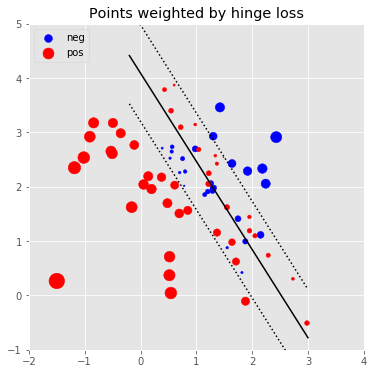

In [196]:
plt_tmp()

### Exercise 7.3

Review the logistic loss and the hinge loss.  What are their gradients/subdifferentials?  

### Answer to 7.3

$$
\ell_{L} (\beta, x_i, y_i) = \log(1 + \exp(-y_i \beta^\top x_i))
\tag{logistic}
$$
$$
\nabla \log(1 + \exp(-y_i \beta^\top x_i)) = - y_i \frac{\exp(-y_i \beta^\top x_i)}{1 + \exp(-y_i \beta^\top x_i)} x_i
$$
$$
= -y_i (1 - \mathbb P \{ y_i | x_i \}) x_i = (\mathbb P\{ Y=1 | x_i\} - 1\{y_i = 1\}) x_i
$$

$$
\ell_{H} (\beta, x_i, y_i) = (1 - y_i \beta^\top x_i))_+
\tag{hinge}
$$
The subdifferential of "positive part"
$\partial a_+ = 1,0$ if $a>0$ and $a <0$ resp. and $[0,1]$ if $a =0$.
Then use chain rule.

Both look like $-y_i \eta_i x_i$ where $\eta_i \in [0,1]$.